LSTM

In [ ]:
pip install numpy torch pmdarima seaborn scipy

In [2]:
# library imports
from nowcast_lstm.LSTM import LSTM
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [62]:
# Updated function to generate lagged data
def gen_lagged_data(metadata, data, last_date, lag):
    last_date = pd.Timestamp(last_date)  # Ensure last_date is a Timestamp object
    lagged_data = data.loc[data.index <= last_date, :].reset_index()
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0]
        
        lagged_data.loc[(len(lagged_data) - pub_lag - lag):, col] = np.nan

    return lagged_data


# Data set up

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm import tqdm
from pathlib import Path
import os

project_dir = Path(os.getcwd()).parent
print(project_dir)

# Define the path to the raw data folder relative to the project directory
data_dir = project_dir / 'data' / 'data_files' / 'processed_data'

# Read data
metadata = pd.read_csv(data_dir / 'meta_monthly_blocks.csv')
data = pd.read_csv(data_dir / 'em_imputed_mq_stationary.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date').sort_index()

# Function to standardize a single column
def z_score(x):
    return (x - x.mean()) / x.std()

# Assuming 'data' is your DataFrame
normalized = data.copy()

# Apply standardization to all columns except "date"
normalized.loc[:, normalized.columns != 'date'] = normalized.loc[:, normalized.columns != 'date'].apply(z_score)

data = normalized

target_variable = "China: GDP: Current Prices:PoP GROWTHRATE"

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date (e.g. 2020-06-01 for Q2 2020)
lags = list(range(-2, 3))

# train and test dates
# Define date ranges
train_start_date = pd.to_datetime('1992-09-30')
test_start_date = pd.to_datetime("2018-01-31")
test_end_date = pd.to_datetime("2024-06-30")
dates = pd.date_range(start=test_start_date, end=test_end_date, freq='QE')
print(dates)

# train and test datasets
test = data.loc[(data.index >= train_start_date) & (data.index <= test_end_date), :]
test.tail()

/Users/leyixu/Desktop/Nowcast
DatetimeIndex(['2018-03-31', '2018-06-30', '2018-09-30', '2018-12-31',
               '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
               '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
               '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-31',
               '2022-03-31', '2022-06-30', '2022-09-30', '2022-12-31',
               '2023-03-31', '2023-06-30', '2023-09-30', '2023-12-31',
               '2024-03-31', '2024-06-30'],
              dtype='datetime64[ns]', freq='QE-DEC')


China: Financial Institutions: Total Deposits Balance: RMB:PoP GROWTHRATE  \
date                                                                                    
2024-02-29                                          -0.489215                           
2024-03-31                                           0.410089                           
2024-04-30                                          -0.923423                           
2024-05-31                                           0.596324                           
2024-06-30                                           0.083920                           

            China: Industrial Added Value Above Designated Size: YoY  \
date                                                                   
2024-02-29                                          -6.410396          
2024-03-31                                           2.835214          
2024-04-30                                           0.367525          
2024-05-31                                          -0.175367          
2024-06-30                                          -0.043757          

            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2024-02-29                       -0.433910   
2024-03-31                        0.216944   
2024-04-30                       -1.842809   
2024-05-31                        1.266851   
2024-06-30                        0.472165   

            Surveyed Urban Unemployment Rate in 31 Big Cities and Towns:PoP chg  \
date                                                                              
2024-02-29                                           1.837971                     
2024-03-31                                           0.000105                     
2024-04-30                                          -0.918828                     
2024-05-31                                          -0.918828                     
2024-06-30                                           0.000105                     

            China: Urban Surveyed Unemployed Rate: Mean:PoP chg  \
date                                                              
2024-02-29                                           0.548887     
2024-03-31                                          -0.968383     
2024-04-30                                           0.007330     
2024-05-31                                          -0.968383     
2024-06-30                                           0.007330     

            China: No. of New Employed Persons in Urban Areas: YTD:PoP GROWTHRATE  \
date                                                                                
2024-02-29                                           0.514275                       
2024-03-31                                           0.510797                       
2024-04-30                                           0.255292                       
2024-05-31                                           0.182226                       
2024-06-30                                          -0.138762                       

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2024-02-29                                           0.615044      
2024-03-31                                          -0.436526      
2024-04-30                                          -0.467455      
2024-05-31                                          -0.900454      
2024-06-30                                           0.129715      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2024-02-29                                           0.708299        
2024-03-31                                          -0.456410        
2024-04-30                                          -0.424057        
2024-05-31                                          -0.909352        
2024-06-30     

In [3]:
data.tail()

China: Financial Institutions: Total Deposits Balance: RMB:PoP GROWTHRATE  \
date                                                                                    
2024-02-29                                          -0.489215                           
2024-03-31                                           0.410089                           
2024-04-30                                          -0.923423                           
2024-05-31                                           0.596324                           
2024-06-30                                           0.083920                           

            China: Industrial Added Value Above Designated Size: YoY  \
date                                                                   
2024-02-29                                          -6.410396          
2024-03-31                                           2.835214          
2024-04-30                                           0.367525          
2024-05-31                                          -0.175367          
2024-06-30                                          -0.043757          

            China: FAI: YTD:PoP GROWTHRATE  \
date                                         
2024-02-29                       -0.433910   
2024-03-31                        0.216944   
2024-04-30                       -1.842809   
2024-05-31                        1.266851   
2024-06-30                        0.472165   

            Surveyed Urban Unemployment Rate in 31 Big Cities and Towns:PoP chg  \
date                                                                              
2024-02-29                                           1.837971                     
2024-03-31                                           0.000105                     
2024-04-30                                          -0.918828                     
2024-05-31                                          -0.918828                     
2024-06-30                                           0.000105                     

            China: Urban Surveyed Unemployed Rate: Mean:PoP chg  \
date                                                              
2024-02-29                                           0.548887     
2024-03-31                                          -0.968383     
2024-04-30                                           0.007330     
2024-05-31                                          -0.968383     
2024-06-30                                           0.007330     

            China: No. of New Employed Persons in Urban Areas: YTD:PoP GROWTHRATE  \
date                                                                                
2024-02-29                                           0.514275                       
2024-03-31                                           0.510797                       
2024-04-30                                           0.255292                       
2024-05-31                                           0.182226                       
2024-06-30                                          -0.138762                       

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2024-02-29                                           0.615044      
2024-03-31                                          -0.436526      
2024-04-30                                          -0.467455      
2024-05-31                                          -0.900454      
2024-06-30                                           0.129715      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2024-02-29                                           0.708299        
2024-03-31                                          -0.456410        
2024-04-30                                          -0.424057        
2024-05-31                                          -0.909352        
2024-06-30     

# Training the model

The model is trained on a rolling basis. So if we are predicting 2000-03-01, the model is trained on data as it would have appeared in 1999-12-01, right before the beginning of the prediction period.

# Testing the model on artificial data vintages

In [54]:
# actual values
actuals = list(test.loc[test.index.isin(dates), target_variable].values)
print(actuals)

[-1.450206507313341, 0.5611694886031315, 0.11202812428810219, 0.5274713493186903, -1.626625636875322, 0.586113532526467, 0.056152338147039335, 0.5188808474114358, -2.5982846207026338, 1.2493953268541158, 0.24243197550438866, 0.6298586526903932, -1.5904586817014839, 0.7467876533854151, -0.017375651397838508, 0.6337926056989818, -1.7167801014415516, 0.3690842996334215, 0.15728980662393582, 0.38963843197205106, -1.510602719792486, 0.3848094568890808, 0.04389891326068392, 0.40879645414163507, -1.5095441922631336, 0.36939882578081334]


In [63]:
# Define lags as 0, 1, 2, and 3 months
lags = [0, 1, 2, 3]

pred_dict = {k: [] for k in lags}
for date in dates:
    for lag in lags:
        # Calculate the cut-off date for training data, ensuring no future data is included
        train_cutoff_date = pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=lag + 1)
        
        # Filter the training data to include only data up to the cutoff date
        train = test.loc[test.index <= train_cutoff_date].copy()
        train = train.reset_index()
        
        # Train the model on this non-contaminated data
        model = LSTM(
            data = train,
            target_variable = target_variable,
            n_timesteps = 6,
            fill_na_func = np.nanmean,
            fill_ragged_edges_func = np.nanmean,
            n_models = 10,
            train_episodes = 50,
            batch_size = 50,
            decay = 0.98,
            n_hidden = 40,
            n_layers = 2,
            dropout = 0.0,
            criterion = torch.nn.MSELoss(),
            optimizer = torch.optim.Adam,
            optimizer_parameters = {"lr":1e-2, "weight_decay":0.0}
        )
        model.train(quiet=False)
        
        # Generate the data available for this date at this artificial vintage
        tmp_data = gen_lagged_data(metadata, test, date, lag)
        print(tmp_data)
        
        # Ensure the 'date' column is correctly formatted
        if 'date' in tmp_data.columns:
            tmp_data['date'] = pd.to_datetime(tmp_data['date'], errors='coerce')
        else:
            raise ValueError("The 'tmp_data' DataFrame does not have a 'date' column.")
        
        # The predict function will give a whole dataframe, only interested in the prediction for this date
        pred = model.predict(tmp_data).loc[lambda x: x.date == date, "predictions"].values[0]
        pred_dict[lag].append(pred)


Training model 1
step :  0 loss :  0.6956879496574402
step :  1 loss :  0.536751925945282
step :  2 loss :  0.2351044863462448
step :  3 loss :  0.18864445388317108
step :  4 loss :  0.1063033938407898
step :  5 loss :  0.04948592558503151
step :  6 loss :  0.02207784354686737
step :  7 loss :  0.020176401361823082
step :  8 loss :  0.024327484890818596
step :  9 loss :  0.018598098307847977
step :  10 loss :  0.015136441215872765
step :  11 loss :  0.009776168502867222
step :  12 loss :  0.006246318109333515
step :  13 loss :  0.006872715428471565
step :  14 loss :  0.005834666546434164
step :  15 loss :  0.0040620011277496815
step :  16 loss :  0.0028258850798010826
step :  17 loss :  0.0019267492461949587
step :  18 loss :  0.002628355287015438
step :  19 loss :  0.0025455234572291374
step :  20 loss :  0.0013513400917872787
step :  21 loss :  0.0009308443986810744
step :  22 loss :  0.0008021492976695299
step :  23 loss :  0.0006060392479412258
step :  24 loss :  0.0007635052315890

  Vintage    RMSE
0       0  0.5022
1       1  0.6404
2       2  0.8696
3       3  0.9799


/var/folders/ns/hcbvd_hd3gxfr2y183d8csgr0000gn/T/ipykernel_8590/4048293938.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance = pd.concat([performance, tmp], ignore_index=True)


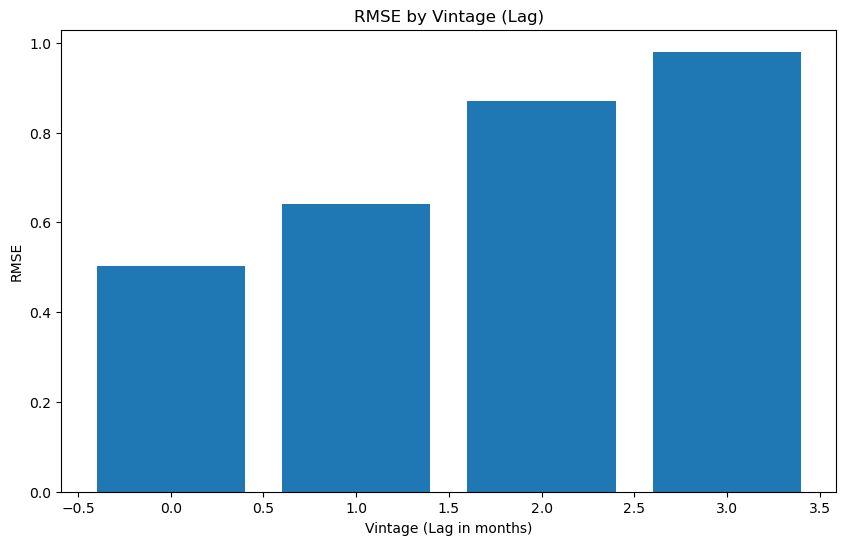

In [64]:
# Calculate RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE"])

# Ensure actuals and predictions are aligned
actuals = data.loc[dates, target_variable]

for lag in lags:
    predictions = pred_dict[lag]
    
    # Remove any NaN values (where predictions weren't made)
    mask = ~(np.isnan(actuals) | np.isnan(predictions))
    actuals_clean = actuals[mask]
    predictions_clean = np.array(predictions)[mask]
    
    rmse = np.sqrt(np.mean((actuals_clean - predictions_clean) ** 2))
    
    tmp = pd.DataFrame({
        "Vintage": [lag],
        "RMSE": [rmse]
    })
    performance = pd.concat([performance, tmp], ignore_index=True)

performance = performance.sort_values("Vintage").reset_index(drop=True)
print(performance.round(4))

# Optionally, you can create a bar plot of the RMSE values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(performance['Vintage'], performance['RMSE'])
plt.title('RMSE by Vintage (Lag)')
plt.xlabel('Vintage (Lag in months)')
plt.ylabel('RMSE')
plt.show()

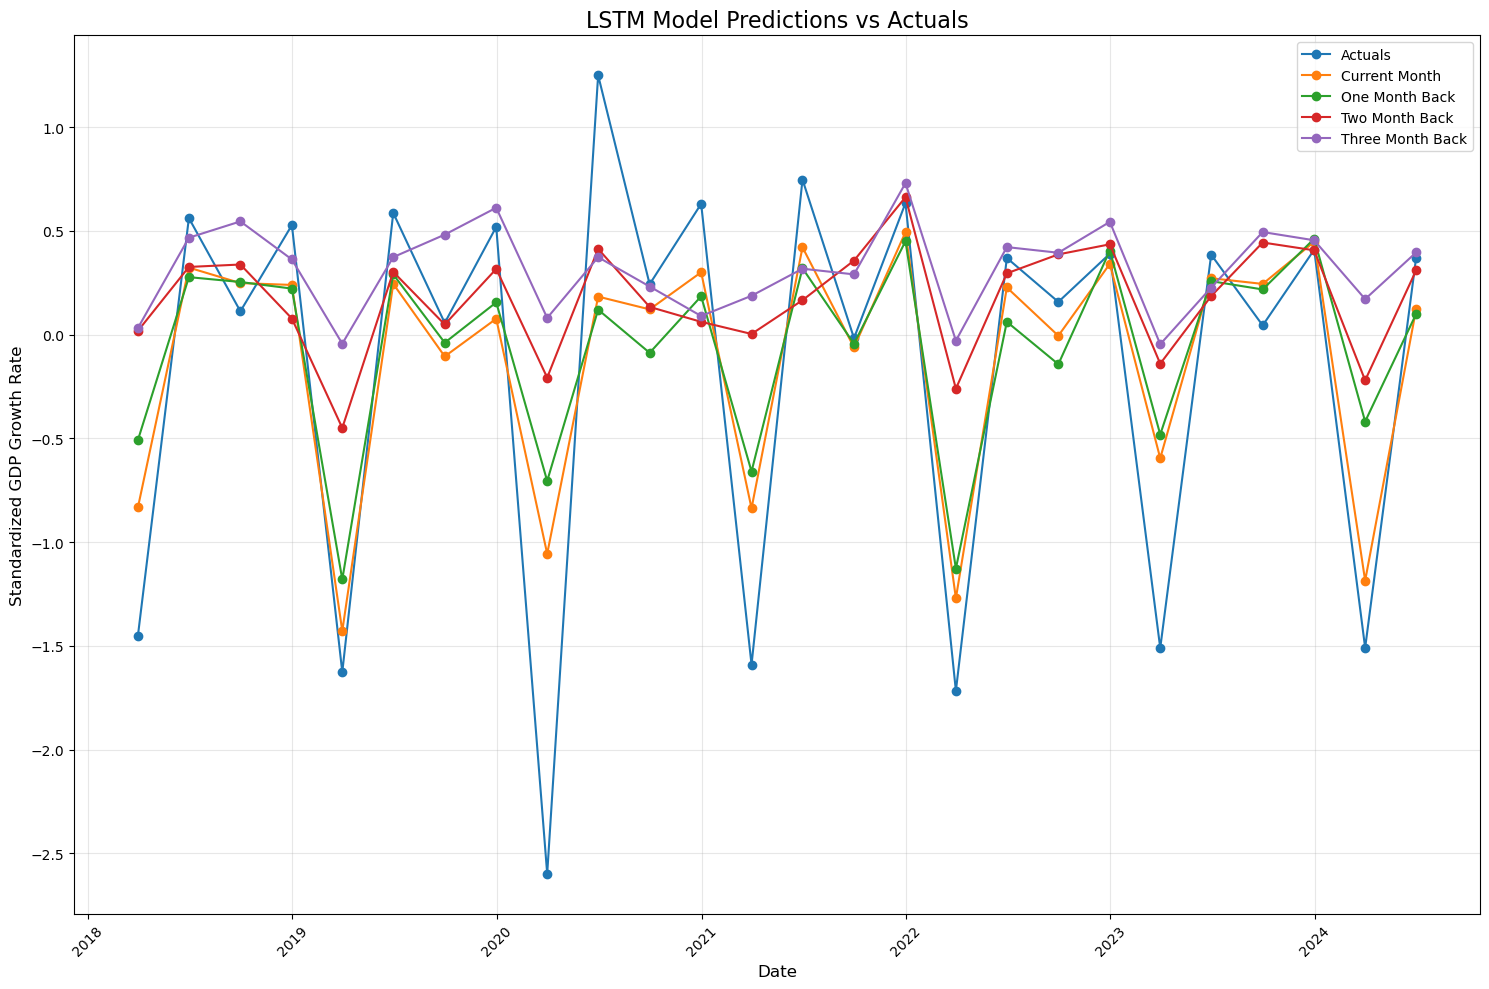

In [65]:
# Plot of predictions vs actuals
plt.figure(figsize=(15, 10))
df = pd.DataFrame({
    "Actuals": actuals,
    "Current Month": pred_dict[0],
    "One Month Back": pred_dict[1],
    "Two Month Back": pred_dict[2],
    "Three Month Back": pred_dict[3]
})

for column in df.columns:
    plt.plot(dates, df[column], label=column, marker='o')

plt.title("LSTM Model Predictions vs Actuals", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Standardized GDP Growth Rate", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Assess and visualize model performance

In [66]:
import pandas as pd
from datetime import datetime

# Convert pred_dict to a DataFrame
df = pd.DataFrame(pred_dict)

# Add a date column
df['date'] = dates

# Reorder columns to have date first
columns = ['date'] + [col for col in df.columns if col != 'date']
df = df[columns]

# Save to CSV with timestamp
filename = f'lstm.csv'
df.to_csv(project_dir / 'results' / filename, index=False)

# Hyperparameter tuning
The process is carried out remotely using a gpu to speed up the process. The results are recorded here. Adjust the parameters according to specific usage.

Results:
{-2: 0.2644906125086237, -1: 0.1765942165320782, 0: 0.1737544684232222, 1: 0.0771388893971711, 2: 0.0366360014505986}
{-2: 'n_timesteps_6_n_hidden_40_n_layers_4_batch_size_200_train_episodes_50', -1: 'n_timesteps_6_n_hidden_40_n_layers_4_batch_size_200_train_episodes_100', 0: 'n_timesteps_6_n_hidden_40_n_layers_4_batch_size_200_train_episodes_200', 1: 'n_timesteps_3_n_hidden_10_n_layers_2_batch_size_100_train_episodes_50', 2: 'n_timesteps_3_n_hidden_10_n_layers_1_batch_size_50_train_episodes_100'}


In [ ]:
import torch
import pandas as pd
import numpy as np
from itertools import product

# Define the hyperparameter grid
param_grid = {
    'n_timesteps': [3, 6, 12],
    'n_hidden': [10, 20, 40],
    'n_layers': [1, 2, 4],
    'batch_size': [50, 100, 200],
    'train_episodes': [50, 100, 200]
}

# Initialize the prediction dictionary
pred_dict = {k: [] for k in lags}
best_score = float('inf')
best_params = None

total_combinations = np.prod([len(v) for v in param_grid.values()])
combination_count = 0

print(f"Total hyperparameter combinations: {total_combinations}")

# Iterate through all combinations of the hyperparameters
for params in product(*param_grid.values()):
    combination_count += 1
    params_dict = dict(zip(param_grid.keys(), params))

    print(f"\nTesting combination {combination_count}/{total_combinations}")
    print(f"Current parameters: {params_dict}")

    # Temporary list to hold predictions for the current hyperparameter combination
    temp_pred_dict = {k: [] for k in lags}

    for date in dates:
        # Prepare the training data
        train = test.loc[test.index <= str(pd.to_datetime(date) - pd.tseries.offsets.DateOffset(months=3))[:10], :]
        train = train.reset_index()

        for n_timesteps in param_grid['n_timesteps']:
            for n_hidden in param_grid['n_hidden']:
                for n_layers in param_grid['n_layers']:
                    for batch_size in param_grid['batch_size']:
                        for train_episodes in param_grid['train_episodes']:

        # Train the LSTM model with the current hyperparameters
                            model = LSTM(
                                data=train,
                                target_variable=target_variable,
                                n_timesteps=n_timesteps,
                                fill_na_func=np.nanmean,
                                fill_ragged_edges_func=np.nanmean,
                                n_models=10,
                                train_episodes=train_episodes,
                                batch_size=batch_size,
                                decay=0.98,
                                n_hidden=n_hidden,
                                n_layers=n_layers,
                                dropout=0.0,
                                criterion=torch.nn.MSELoss(),
                                optimizer=torch.optim.Adam,
                                optimizer_parameters={"lr": 1e-2, "weight_decay": 0.0}
                            )
                            model.train(quiet=True)
        # Predict for each lag
        for lag in lags:
            tmp_data = gen_lagged_data(metadata, test, date, lag)
            
            # the predict function will give a whole dataframe, only interested in the prediction for this date
            pred = model.predict(tmp_data).loc[lambda x: x.date == date, "predictions"].values[0]
            pred_dict[lag].append(pred)

    # Evaluate the performance of the current hyperparameter combination
    # Assuming you have a function to calculate RMSE across all dates and lags
    current_score = np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2))
    print(f"Current RMSE: {current_score:.4f}")

    # Update the best model if the current one is better
    if current_score < best_score:
        best_score = current_score
        best_params = params_dict
        pred_dict = temp_pred_dict.copy()  # Save the best predictions
        print(f"New best score found: {best_score:.4f}")

print("Best parameters found:", best_params)
print("Best score (RMSE):", best_score)
